# FYSC12: Beta decay and Fermi Kurie plot
## Data analysis code and lab notebook

### Introduction
* Intro text here

### Some basic things on Python:

In [1]:
## assign a variable:
myvar = 23.5
## print a variable to the notebook:
print(myvar)
## print text + variable:
print('this is myvar: {}'.format(myvar))
## help with any function:
help(print)

## create an array

23.5
this is myvar: 23.5
Help on built-in function print in module builtins:

print(...)
    print(value, ..., sep=' ', end='\n', file=sys.stdout, flush=False)
    
    Prints the values to a stream, or to sys.stdout by default.
    Optional keyword arguments:
    file:  a file-like object (stream); defaults to the current sys.stdout.
    sep:   string inserted between values, default a space.
    end:   string appended after the last value, default a newline.
    flush: whether to forcibly flush the stream.



For data storage and analysis, we rely on the *numpy* and *scipy* packages. And to plot things, we use the *matplotlib* library. We need to import both before the first use and initialize the interactive plots inside the notebook:

In [2]:
import numpy as np
import scipy
import matplotlib
# choose a backend for web applications; remove for stand-alone applications:
matplotlib.use('Agg')
import matplotlib.pyplot as plt
# enable interactive notebook plots (
# alternative: use 'inline' instead of 'notebook' for static images)
%matplotlib notebook

### Let's take some data!
#### describe your experiment and settings here:

.......

**Important**: write down any settings you apply! And take pictures of the setup/sources.

#### Load the data from the MCA
We have a little helper library called MCA.py that we load here. It provides a new class *Spectrum* and a routine to load (ASCII) files from the MCA: *load_spectrum("filename")*

In [3]:
import MCA
sr90 = MCA.load_spectrum(filename =  'beta_lab_calib/sr90.Spe')
sr90.name = "Sr-90"

Now it's time to plot the data we just measured!
Run the cell below to see the result appear inside the notebook:

### Plot the first data

<IPython.core.display.Javascript object>


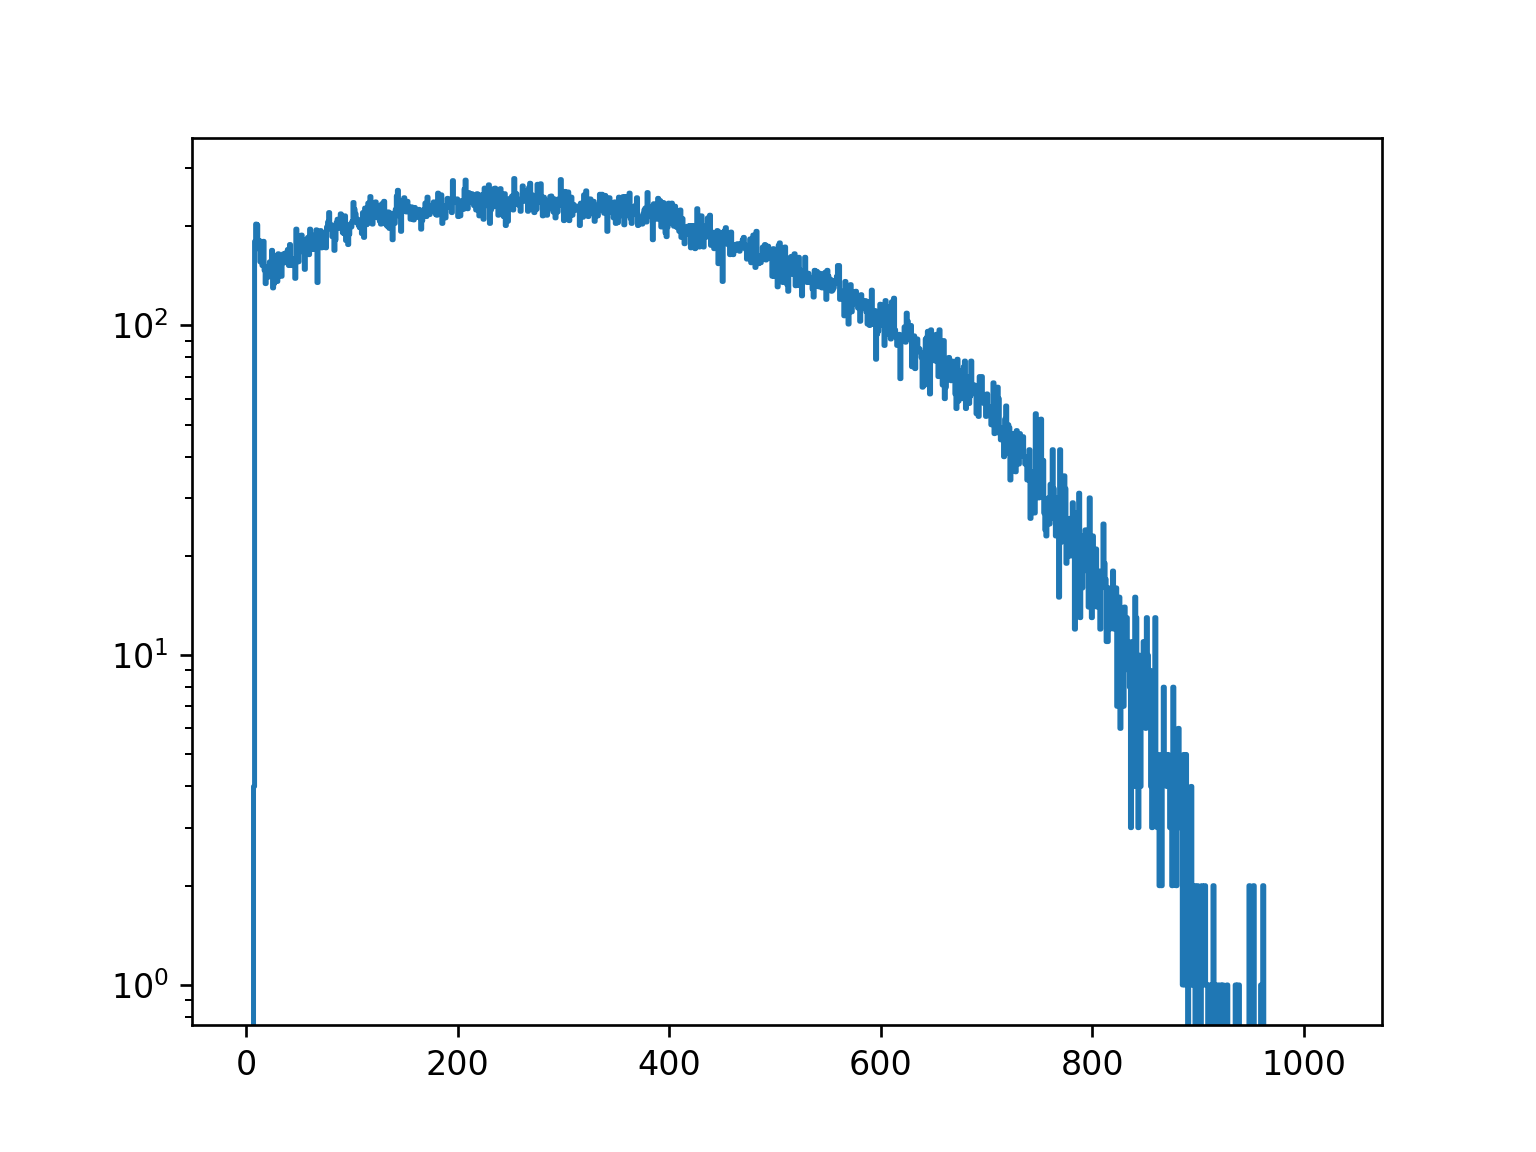

In [4]:
fig, axes = plt.subplots() # makes new plot
axes.plot(sr90.x, sr90.y, linestyle="steps")

## Could be useful to see this in log scale..?
plt.yscale('log')

The result looks (hopefully) more-or-less identical to what we have seen in the MCA software. Good, let's proceed with the analysis then!

**Note**: if you use a pure Python program (not a notebook like we do today) and want to plot with matplotlib, then you need to adjust the indicated lines around the matplotlib import statement add the *plt.show()* command (without arguments) to actually _show_ the plots in a separate window.

#### Questions:
- what is the Q value (in channels) that you read off the plot above? How confident (in units of channels) are you with that reading?

**Answer here**:

## Energy calibration of the detector
We have two different sources available: Cs-137 and Bi-207

Your task:
- have your lab supervisor hand you a source and instruct you to place it at the measurement location
- take a spectrum
- while waiting for the measurement: study the incoming MCA spectrum (alternatively, plot the already recorded data here)
- research at what intensities and energies the source emitts internal conversion electrons (electron capture process). *Hint:* The Nudat database might be useful: http://www.nndc.bnl.gov/nudat2
- identify what emissions contribute to the peaks you see in the spectrum
- our detector cannot resolve small differences in energy, so the peaks we see might stem from several emissions at different energies; calculate the mean energy taking into account the (relative) intensities

When you are ready, plot the new raw data:

<IPython.core.display.Javascript object>


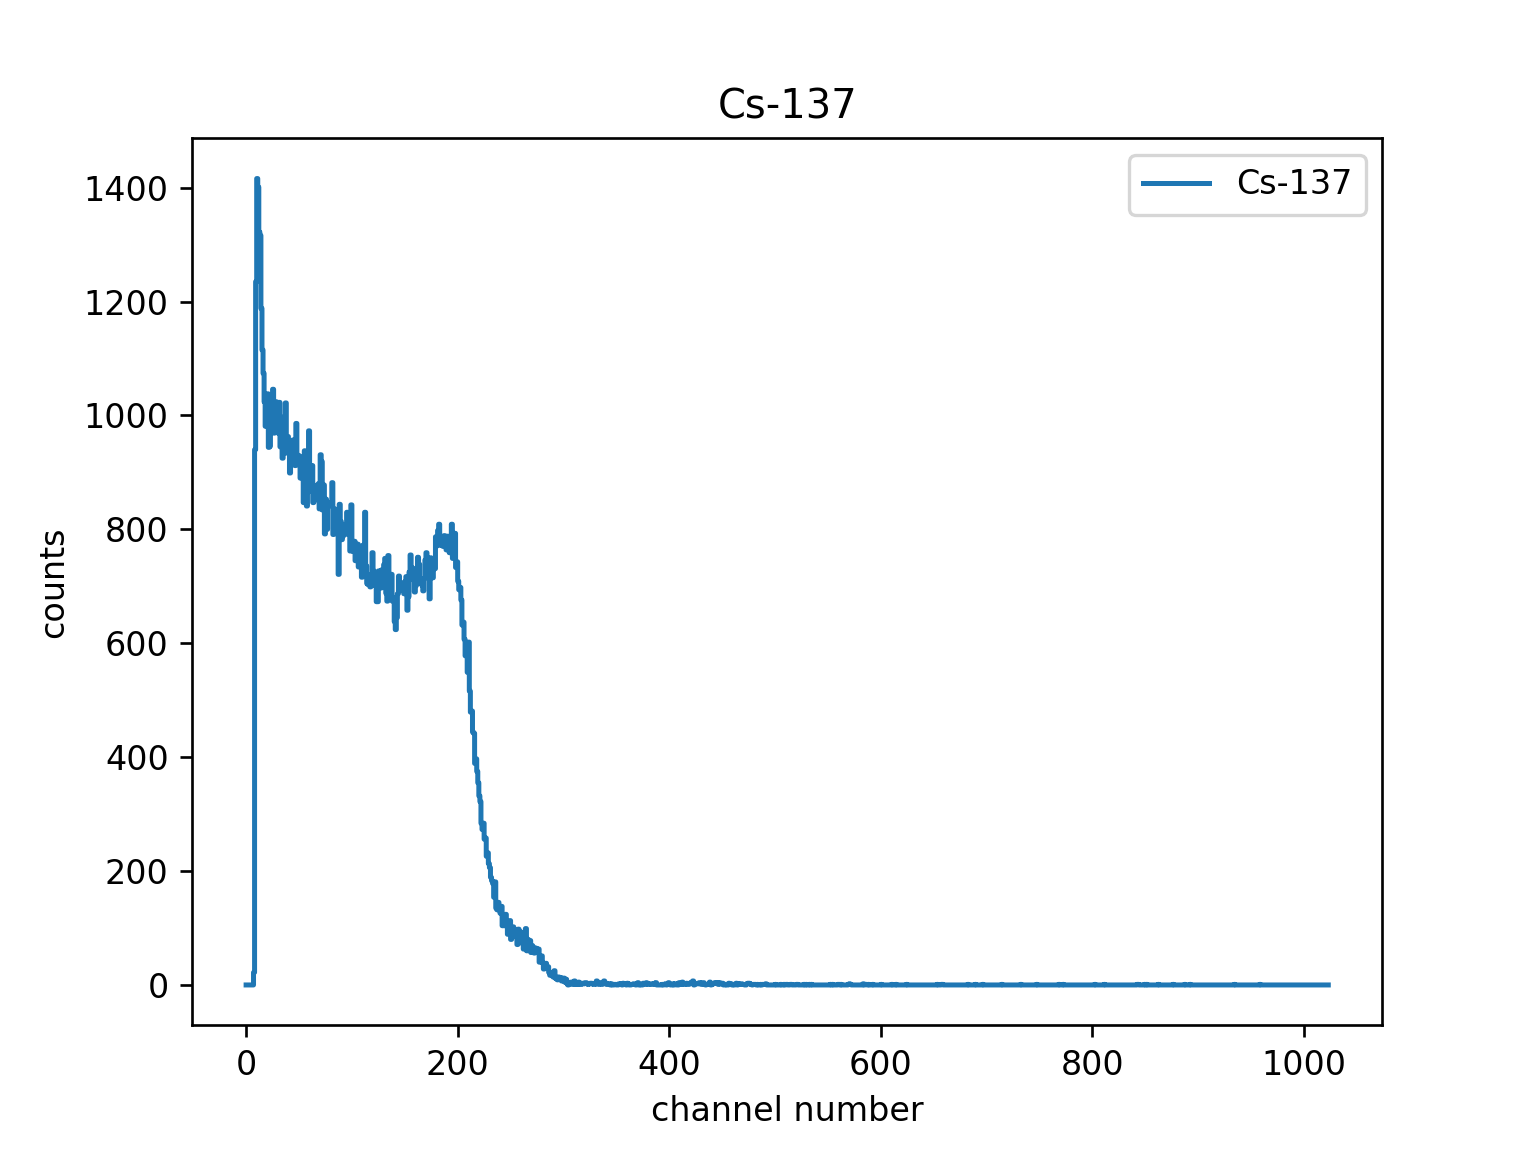

In [5]:
calsource1 = MCA.load_spectrum(filename = 'beta_lab_calib/cs137.Spe')
calsource1.name = "Cs-137"

fig, axes = plt.subplots() # makes new plot
plt.plot(calsource1.x, calsource1.y, linestyle="steps", label = calsource1.name)

## Let's make this plot a little nicer!

plt.xlabel('channel number')
plt.ylabel('counts')
plt.title(calsource1.name)
plt.legend()


### Determining the IC peak position and width via Gaussian fits

- what is the advantage of using Gaussian fits over reading off the value by eye?

<IPython.core.display.Javascript object>


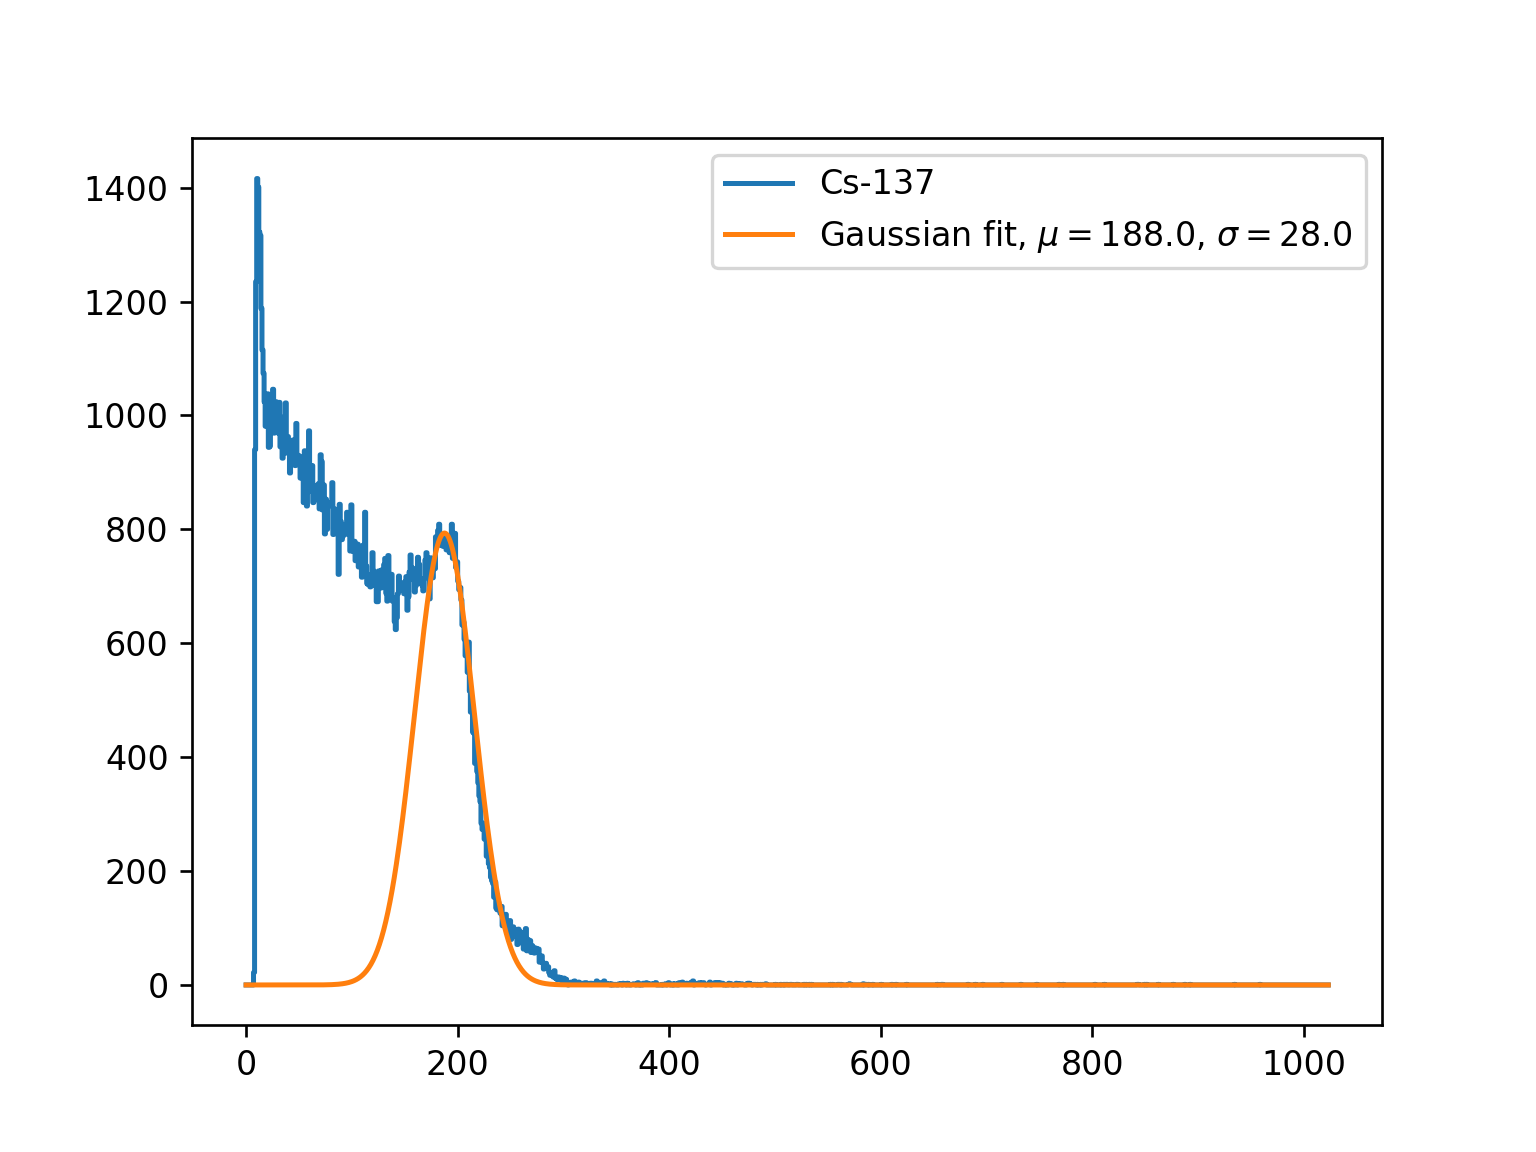

Fit result: A: 793.5979, mu: 187.5408, sigma: 28.0156
Fit uncertainties (one std deviation errors) [%]: [ 0.69049162  0.2550685   3.54326843]


In [35]:
fig, axes = plt.subplots() # makes new plot

axes.plot(calsource1.x, calsource1.y, label = calsource1.name, linestyle="steps")

def gaussfcn(x, *p):
    """ gauss function to be used for fits to the data"""
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

class Gauss:
    """A class to hold coefficients for Gaussian distributions"""
    def __init__(self, A, mu, sigma):
        self.A = A
        self.mu = mu
        self.sigma = sigma
    def value(self, x):
        return gaussfcn(x, self.A, self.mu, self.sigma)
    def as_string(self, ndigits=4):
        return str("A: {}, mu: {}, sigma: {}".format(round(self.A, ndigits),
                                                     round(self.mu, ndigits),
                                                     round(self.sigma, ndigits)))

npoints = 20
pos = 193.00
# find the index of the x value closest to the position to be fitted
idx = np.searchsorted(calsource1.x, pos)

## p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [calsource1.y[idx], pos, 1.]

## use the scipy curve_fit routine (uses non-linear least squares to perform the fit)
## http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
## fit using "slices" of the arrays with +/- npoints around the idx position
coeff, var_matrix = scipy.optimize.curve_fit(gaussfcn,
                                calsource1.x[idx-npoints:idx+npoints],
                                calsource1.y[idx-npoints:idx+npoints],
                                p0=p0)
## create a Gauss object with the fitted coefficients for better code readability
g = Gauss(*coeff)

## compute one standard deviation errors on the parameters from the covariance matrix
perr = np.sqrt(np.diag(var_matrix))

print("Fit result: "+g.as_string())
print("Fit uncertainties (one std deviation errors) [%]: {}".format(100*perr/coeff))

## plot the gaussian fit
axes.plot(calsource1.x, g.value(calsource1.x), 
              label = r'Gaussian fit, $\mu={}$, $\sigma={}$'.format(round(g.mu),round(g.sigma)))

# show legend
plt.legend()


# TODO!
# Happy with the result? "save" a reference to this result 
# under a meaningful name so you can access it easily later!
calsource1_gfit = g

In [8]:
import fithelpers
gfits = fithelpers.fit_all_gaussians(calsource1.x, calsource1.y, loglevel="WARNING")
# if the fit did not work, you can add fits at specific positions:
# gfits.append(fithelpers.fit_gaussian_at_pos(calsource1.x, calsource.y, pos=....))

<IPython.core.display.Javascript object>


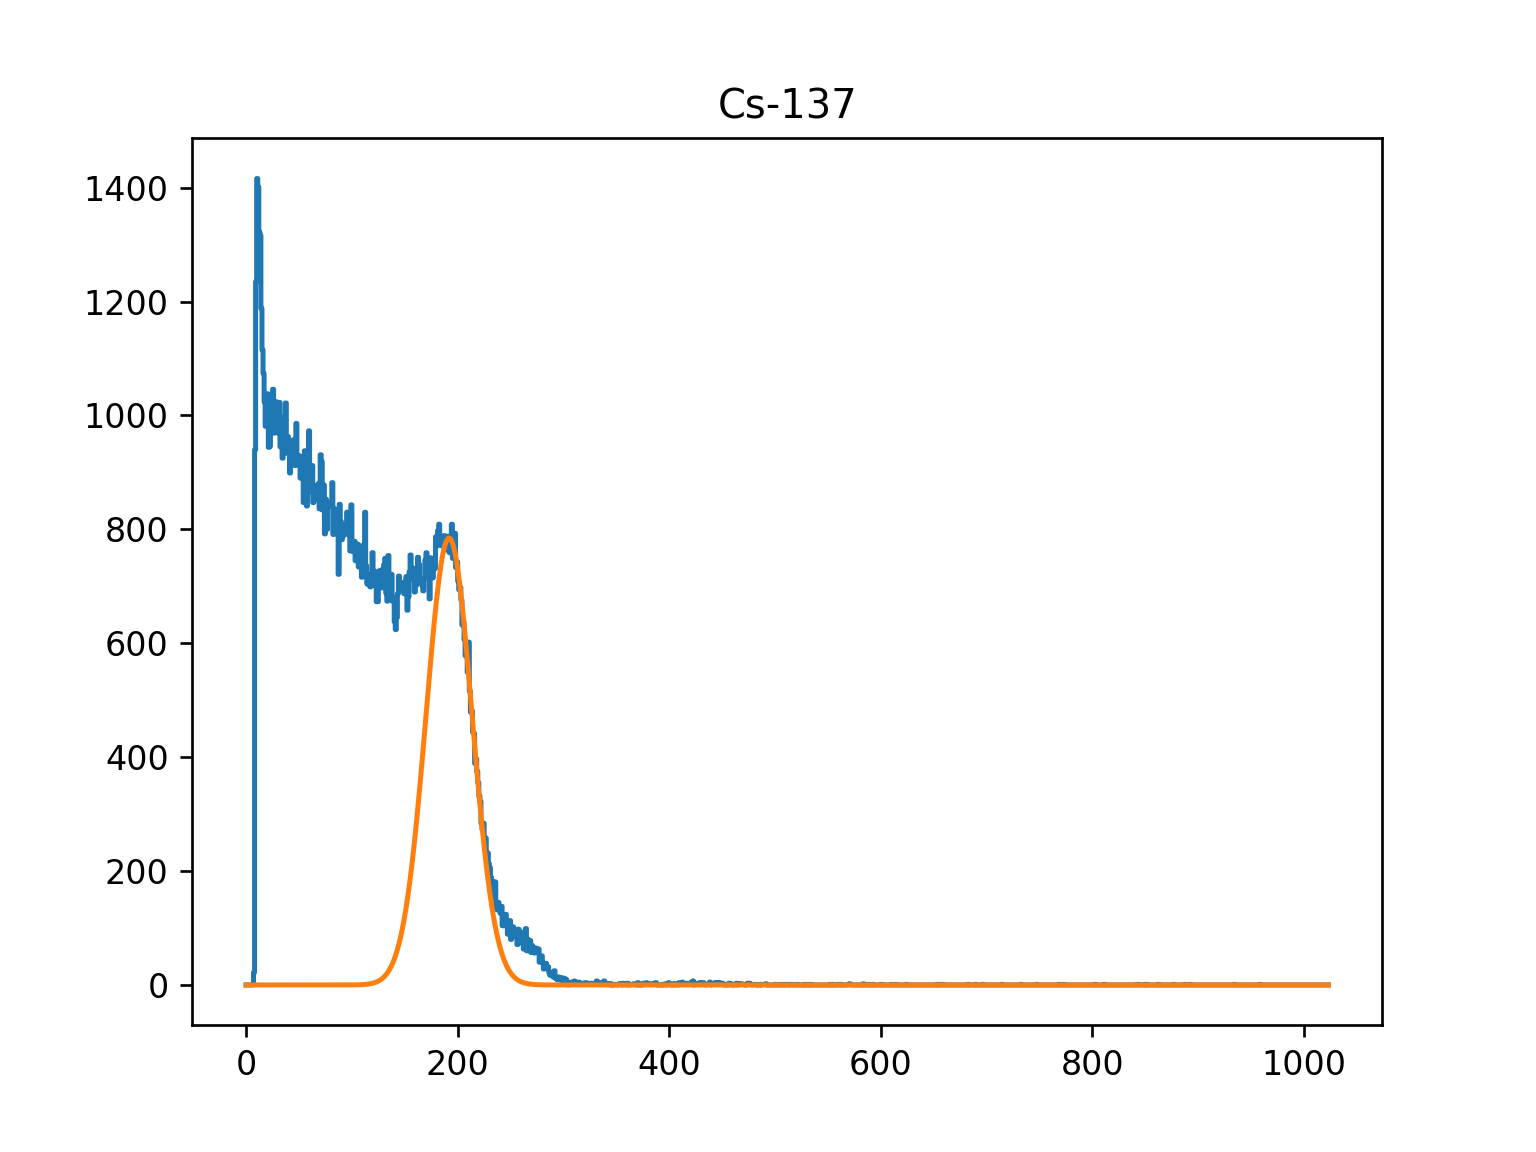

Text(0.5,1,'Cs-137')

In [9]:
fig, axes = plt.subplots() # makes new plot

axes.plot(calsource1.x, calsource1.y, label = calsource1.name, linestyle="steps")
for g in gfits:
    ## plot the gaussian fit
    axes.plot(calsource1.x, g.value(calsource1.x), 
              label = "Gaussian fit, sgm="+str(round(g.sigma)))
plt.title(calsource1.name)


<IPython.core.display.Javascript object>


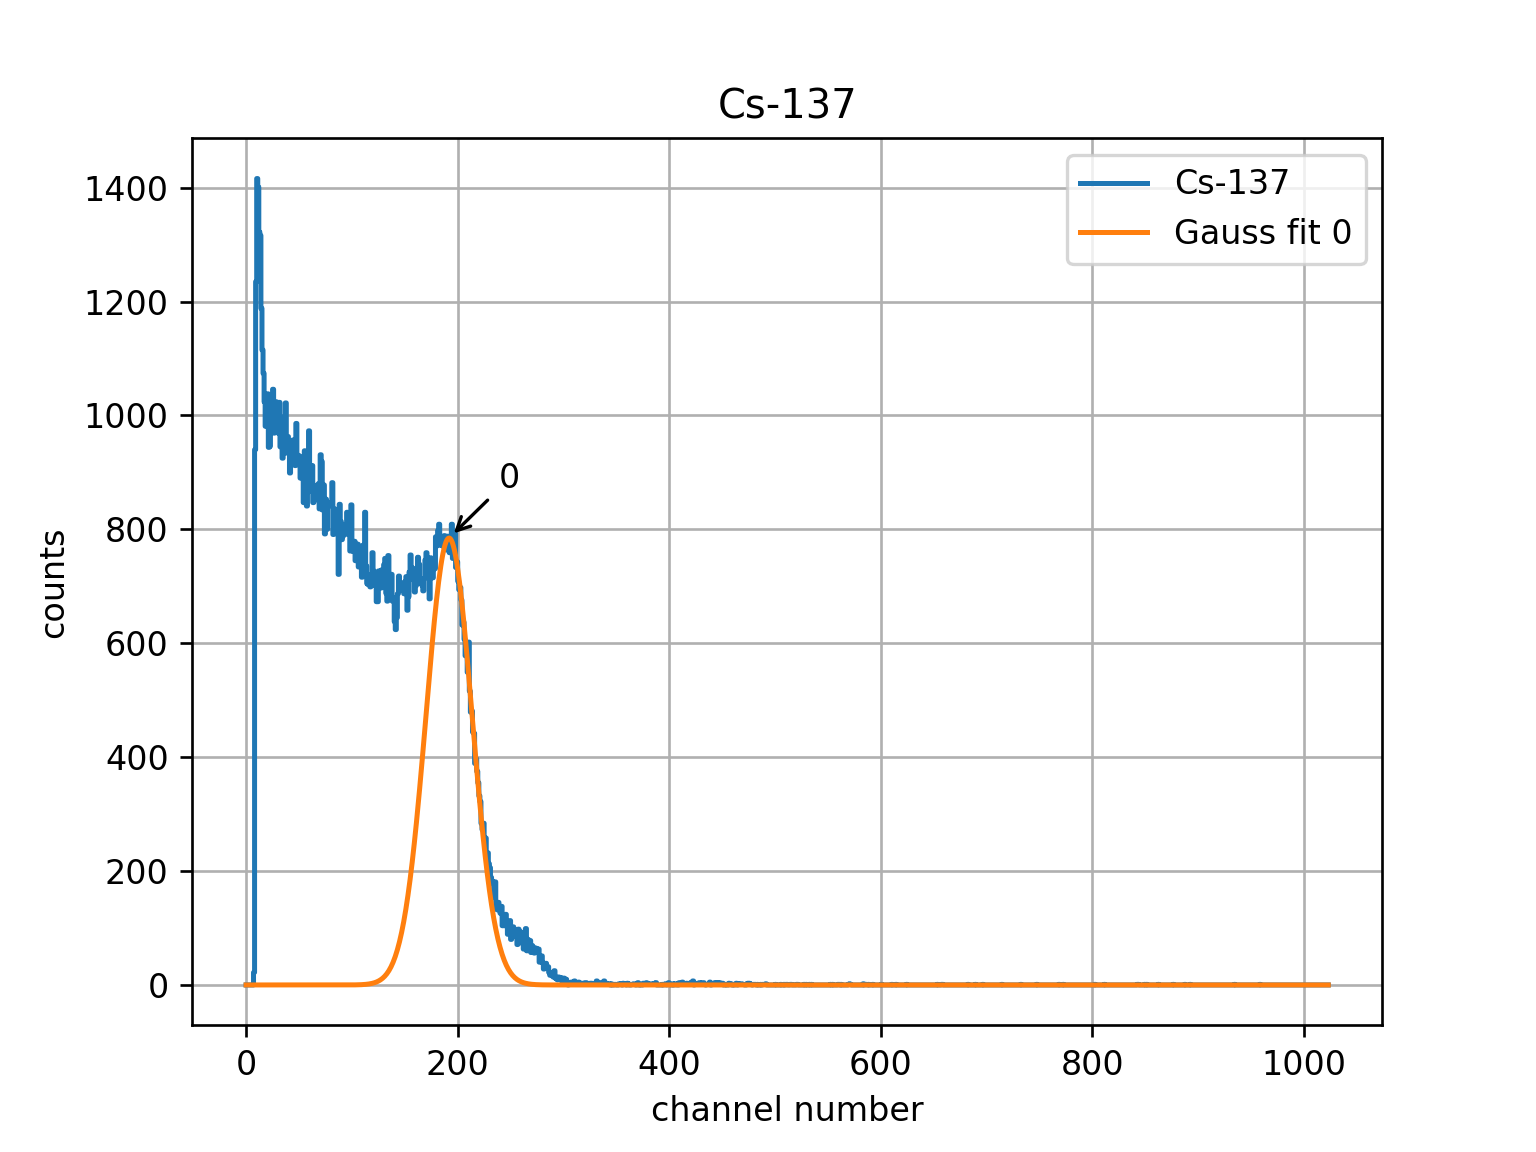

Fitted Gaussian #0: A: 784.8292, mu: 191.8399, sigma: 21.6692


In [10]:
## set up a new plot
fig, axes = plt.subplots() # makes new plot
plt.grid(True)
plt.xlabel('channel number')
plt.ylabel('counts')
plt.title(calsource1.name)

## plot the cs-137 data
plt.plot(calsource1.x, calsource1.y, linestyle='steps',label=calsource1.name)
## loop over all the fit results and enumerate them with an index
for idx, g in enumerate(gfits):
    ## print a line with the fit result
    print("Fitted Gaussian #{}: {}".format(idx, g.as_string()))
    ## plot this gaussian fit too
    plt.plot(calsource1.x, g.value(calsource1.x), 
             label="Gauss fit {}".format(idx))
    ## add a label to the peak position with the fit index
    plt.annotate(idx,
            xy=(g.mu, g.A), xycoords='data', # where to point to
            xytext=(15, 15), textcoords='offset points', # offset
            arrowprops=dict(arrowstyle="->")) # arrowstyle
    
plt.legend() # make legend visible


### Identify the peak and associate an energy to it

In [11]:
calsource1_channel = [ gfits[0].mu ]
calsource1_sigma   = [ gfits[0].sigma ]


In [12]:
calsource1_E = []
calsource1_E.append(1e-3*(624.216*7.79 + 655.668*1.402 + 660.364*0.300)/(7.79+1.402+0.300))
print ("Mean E peak #1: {} MeV".format(calsource1_E[0]))

Mean E peak #1: 0.6300040429835649 MeV


### Now repeat the above steps for the 2nd calibration source
- start the data taking and study the incoming MCA spectrum 
- research at what intensities and energies the source emitts internal conversion electrons 
- identify what emissions contribute to the peaks we see
- calculate the mean energy taking into account the (relative) intensities

In [13]:
calsource2_E = []
calsource2_E.append(((0.4816935 * 1.537) + (0.5538372 * 0.442) + 
                     (0.5658473 * 0.111)) / (1.537 + 0.442 + 0.111))
print ("Mean E peak #1: {} MeV".format(calsource2_E[0]))

calsource2_E.append((0.975651*7.08 + 1.047795*1.84 + 1.01059805*0.44)/(7.08+1.84+0.44))
print ("Mean E peak #2: {} MeV".format(calsource2_E[1]))

calsource2_E.append((1.682224* 0.0238 + 1.754367 * 0.0034)/(0.0238 + 0.0034))
print ("Mean E peak #3: {} MeV".format(calsource2_E[2]))


Mean E peak #1: 0.5014200967464115 MeV
Mean E peak #2: 0.9914759638888889 MeV
Mean E peak #3: 1.6912418749999998 MeV


<IPython.core.display.Javascript object>


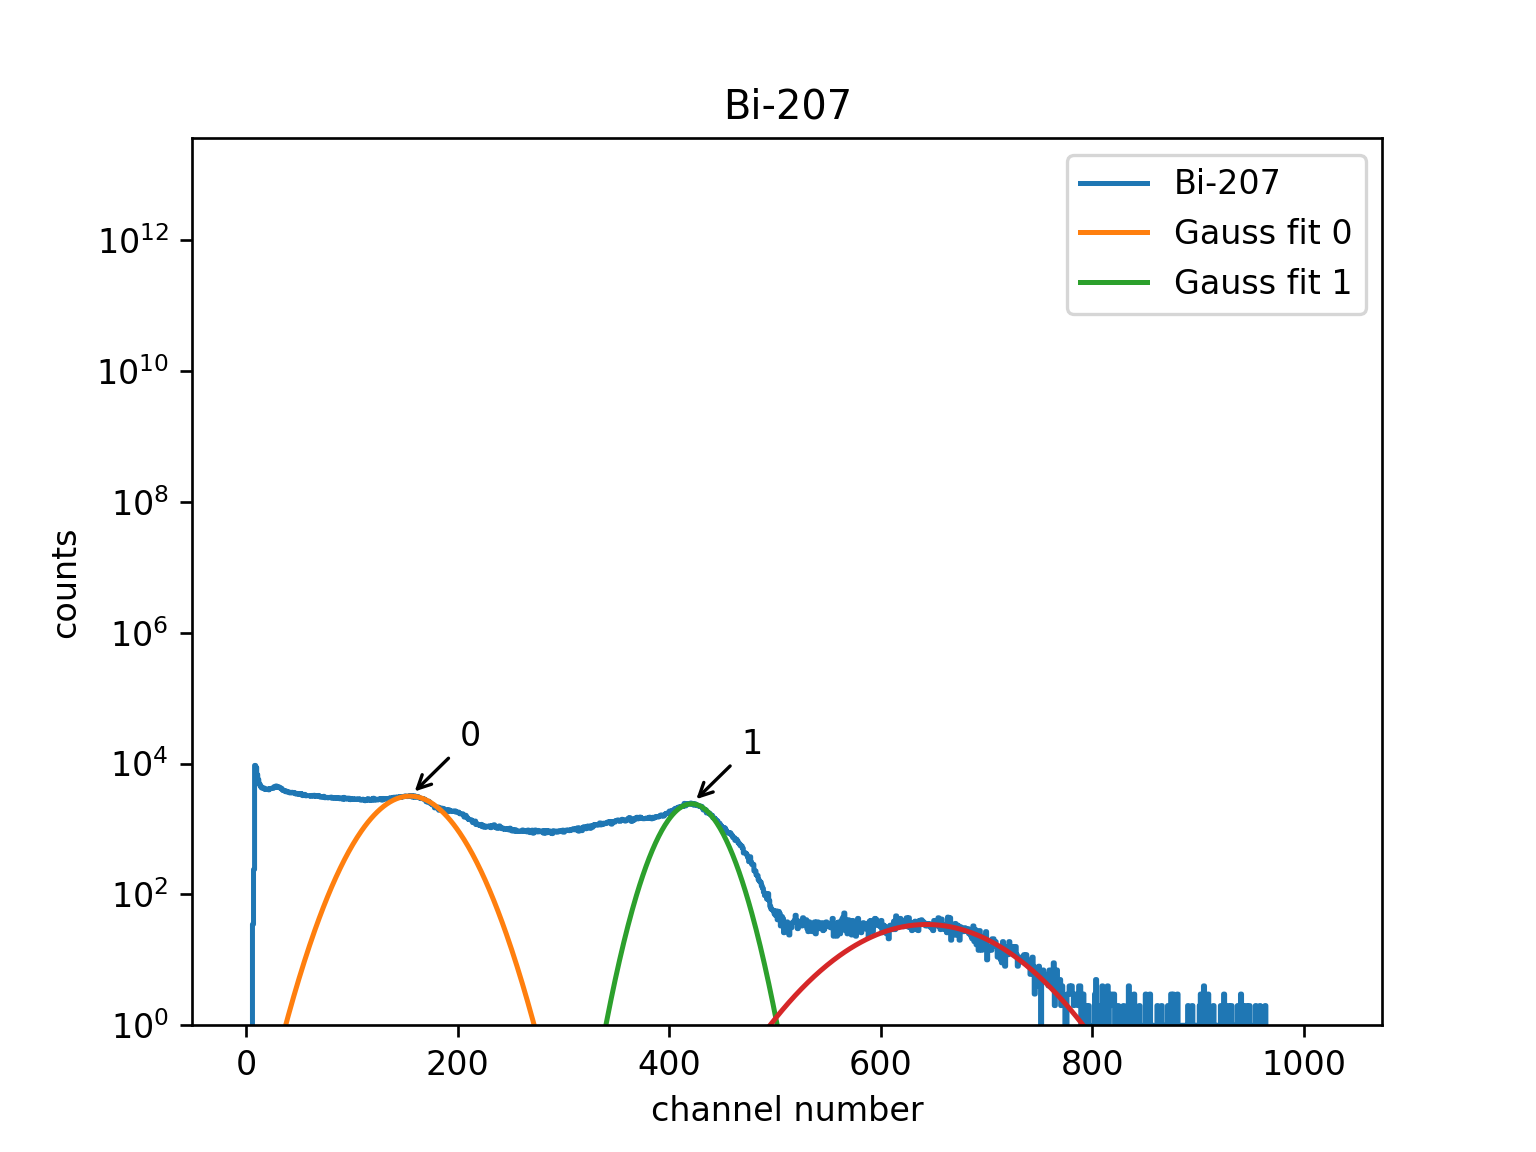

Fitted Gaussian #0: A: 3185.5666, mu: 154.8564, sigma: 29.2515
Fitted Gaussian #1: A: 2426.7681, mu: 421.0883, sigma: 20.5132


In [14]:
calsource2 = MCA.load_spectrum(filename = 'beta_lab_calib/bi207.Spe')
calsource2.name = "Bi-207"
gfits2 = fithelpers.fit_all_gaussians(calsource2.x, calsource2.y, loglevel="WARNING")

fig, axes = plt.subplots() # makes new plot
plt.plot(calsource2.x, calsource2.y, linestyle="steps", label = calsource2.name)

for idx, g in enumerate(gfits2):
    print("Fitted Gaussian #{}: {}".format(idx, g.as_string()))
    plt.plot(calsource2.x, g.value(calsource2.x), 
             label="Gauss fit {}".format(idx))
    plt.annotate(idx,
            xy=(g.mu, g.A), xycoords='data', # where to point to
            xytext=(15, 15), textcoords='offset points', # offset
            arrowprops=dict(arrowstyle="->")) # arrowstyle
    
## Let's make this plot a little nicer!
plt.xlabel('channel number')
plt.ylabel('counts')
plt.yscale('log')
plt.ylim(ymin=1)
plt.title(calsource2.name)
plt.legend()

Let's try to fit even the third (and weakest) peak! Try to make it visible in the plot above and perform a fit at the position you identified by eye using *fithelpers.fit_gaussian_at_pos()*:

In [15]:
g3rd = fithelpers.fit_gaussian_at_pos(calsource2.x, calsource2.y, pos=661, npoints=30)
plt.plot(calsource2.x, g3rd.value(calsource2.x), label="3rd peak")

#### Now assemble above results into data structures we can plot later

In [16]:
calsource2_channel = [ gfits2[0].mu, gfits2[1].mu, g3rd.mu ]
calsource2_sigma   = [ gfits[0].sigma, gfits2[1].sigma, g3rd.sigma ]

### Plot the energy calibration figure

<IPython.core.display.Javascript object>


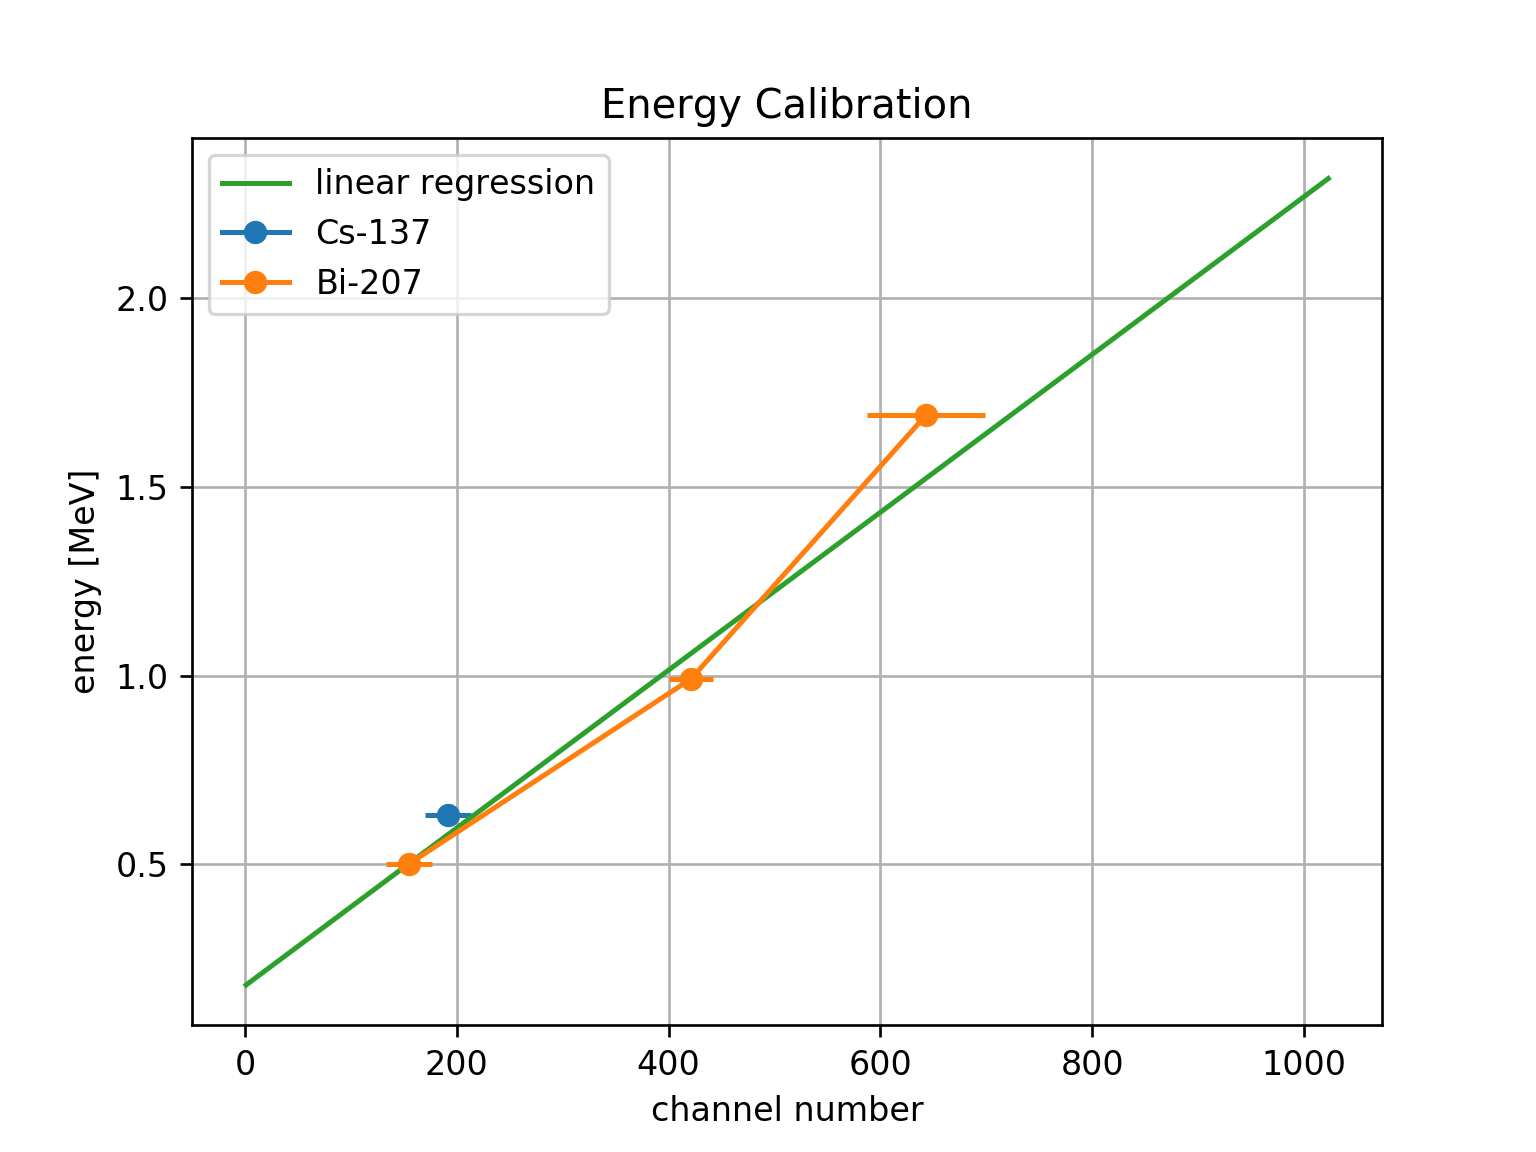

Determined calibration constants from linear regression: E [MeV] = 0.00209091301329*N_ch + 0.178413450409
Slope: +/- 8.633348919807439%
Intercept: +/- 31.604414964336613%
Reloading sr90 spectrum
Applying calibration constants


<IPython.core.display.Javascript object>


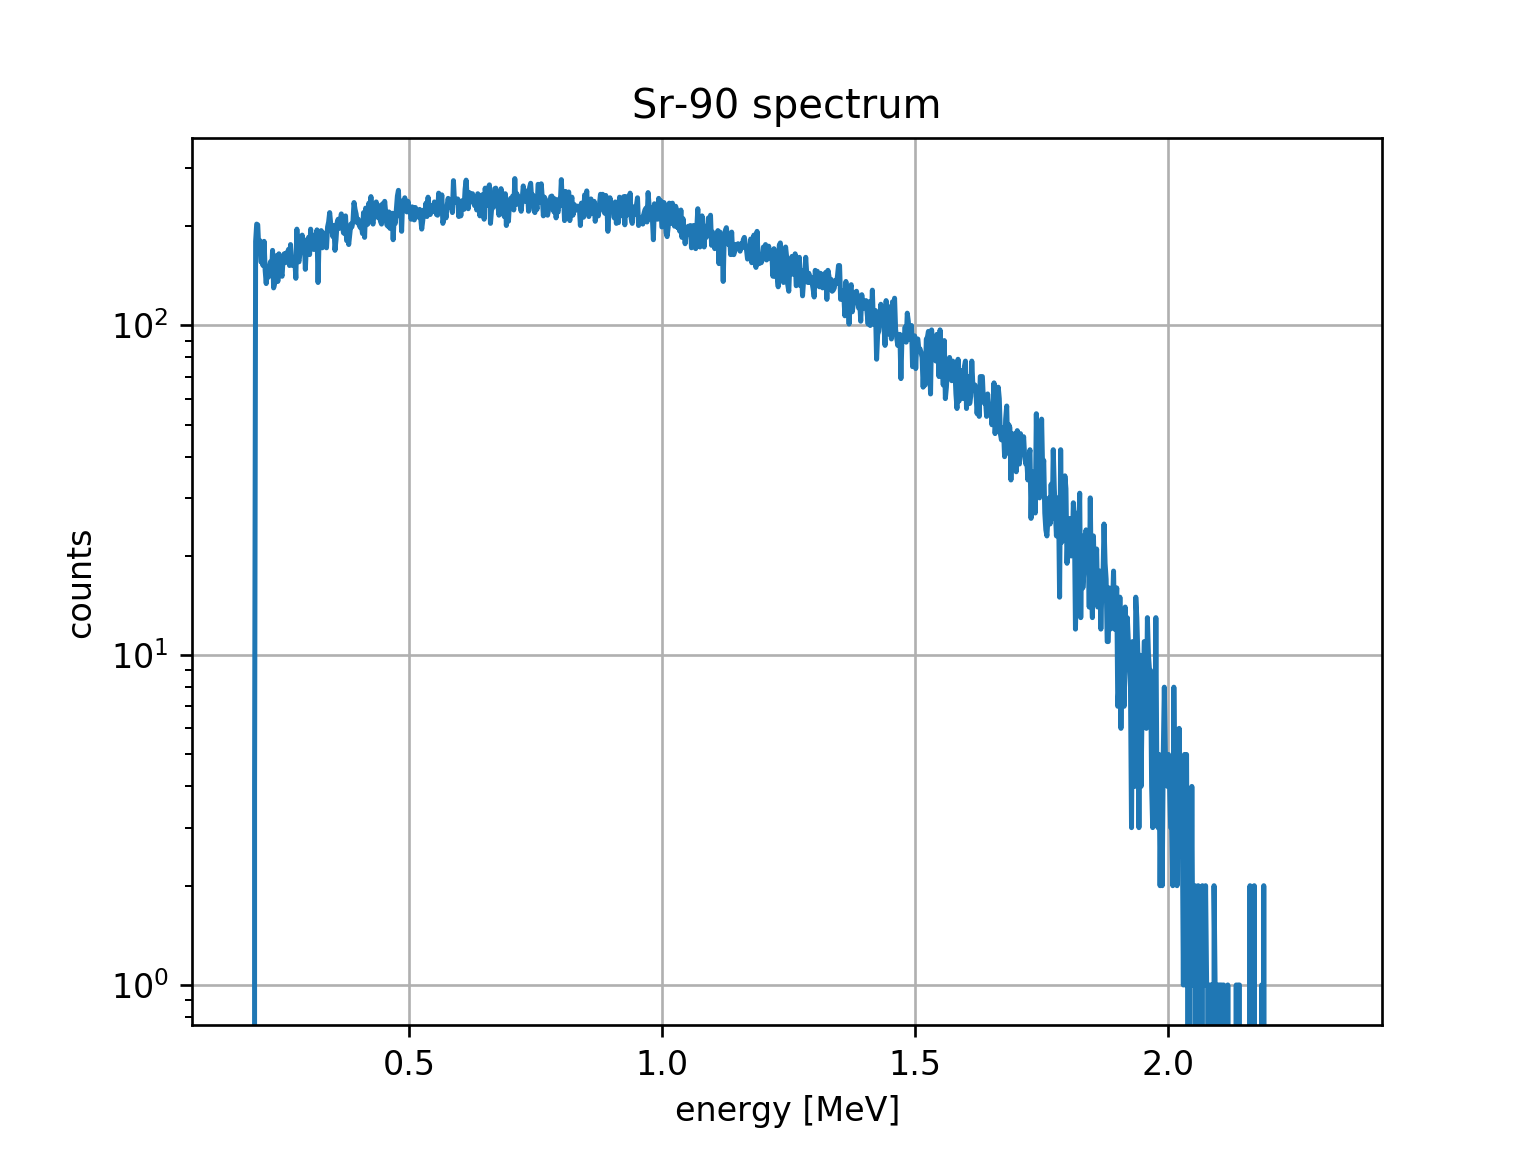

In [21]:
fig, axes = plt.subplots() # makes new plot
plt.grid(True)
plt.xlabel('channel number')
plt.ylabel('energy [MeV]')
plt.title("Energy Calibration")
## PLOT the energy calibration data including uncertainties
plt.errorbar(x=calsource1_channel, 
             y=calsource1_E, 
             xerr=calsource1_sigma, 
             marker='o',
             label=calsource1.name)

plt.errorbar(x=calsource2_channel, 
             y=calsource2_E, 
             xerr=calsource2_sigma, 
             marker='o',
             label=calsource2.name)

## might want to COMBINE data arrays from different calibration sources for the fit:
## use
## new_list = list1 + list2
## to do so. Then change the data set in the fit command.

## linear regression of the data
## http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
## or "help(scipy.stats.linregress)"
slope = 1.
intercept = 0.
# .... something is missing here....

## ADVANCED METHOD TO FIT:
## use "curve_fit" which allows to take uncertainties into account!
## http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
## or "help(scipy.optimize.curve_fit)"

## curve_fit assumes sigma is on the y values -- need to "invert" fit (y(x) -> x(y))
popt, pcov = scipy.optimize.curve_fit(f = fithelpers.inverseline, 
                                        xdata = calsource1_E + calsource2_E,
                                        ydata = calsource1_channel + calsource2_channel,
                                        p0 = [1, 1],
                                        sigma = calsource1_sigma + calsource2_sigma,
                                        absolute_sigma=True
                                     )
## calculate the error on the parameters from the covariance matrix
perr = np.sqrt(np.diag(pcov))
slope = popt[0]
intercept = popt[1]

print("Determined calibration constants from linear regression: E [MeV] = "+str(slope)+"*N_ch + " + str(intercept))
print("Slope: +/- {}%".format(100*perr[0]/popt[0]))
print("Intercept: +/- {}%".format(100*perr[1]/popt[1]))
x = np.arange(1,1024)
plt.plot(x,slope*x+intercept,label="linear regression")
plt.legend()

## apply energy calibration
print("Reloading {} spectrum".format(sr90.name))
sr90 = MCA.load_spectrum(filename =  sr90.filename)
print("Applying calibration constants")
sr90.calibrate(slope,intercept)

fig, axes = plt.subplots() # makes new plot
plt.grid(True)
plt.ylabel('counts')
plt.xlabel('energy [MeV]')
plt.title("Sr-90 spectrum")
plt.yscale('log')
plt.plot(sr90.x,sr90.y,label="Sr-90")


### Energy calibration, optional steps:
- can you demonstrate that the peaks we have identified in fact stem from electrons? How?
- improve the calibration by taking into account all IC emissions from Bi-207 and Cs-137
- improve the fit by taking into account uncertainties!
- how can you evaluate the quality of the fit? Look into the documentation (or code) of the routine and interpret what information it returns!

## Fermi-Kurie Plot
Let's calculate $Q-T_e$ and look at the resulting distribution!

*You are lucky, all the formulars have already been typed in -- and look how easy Python makes the calculations!*

<IPython.core.display.Javascript object>


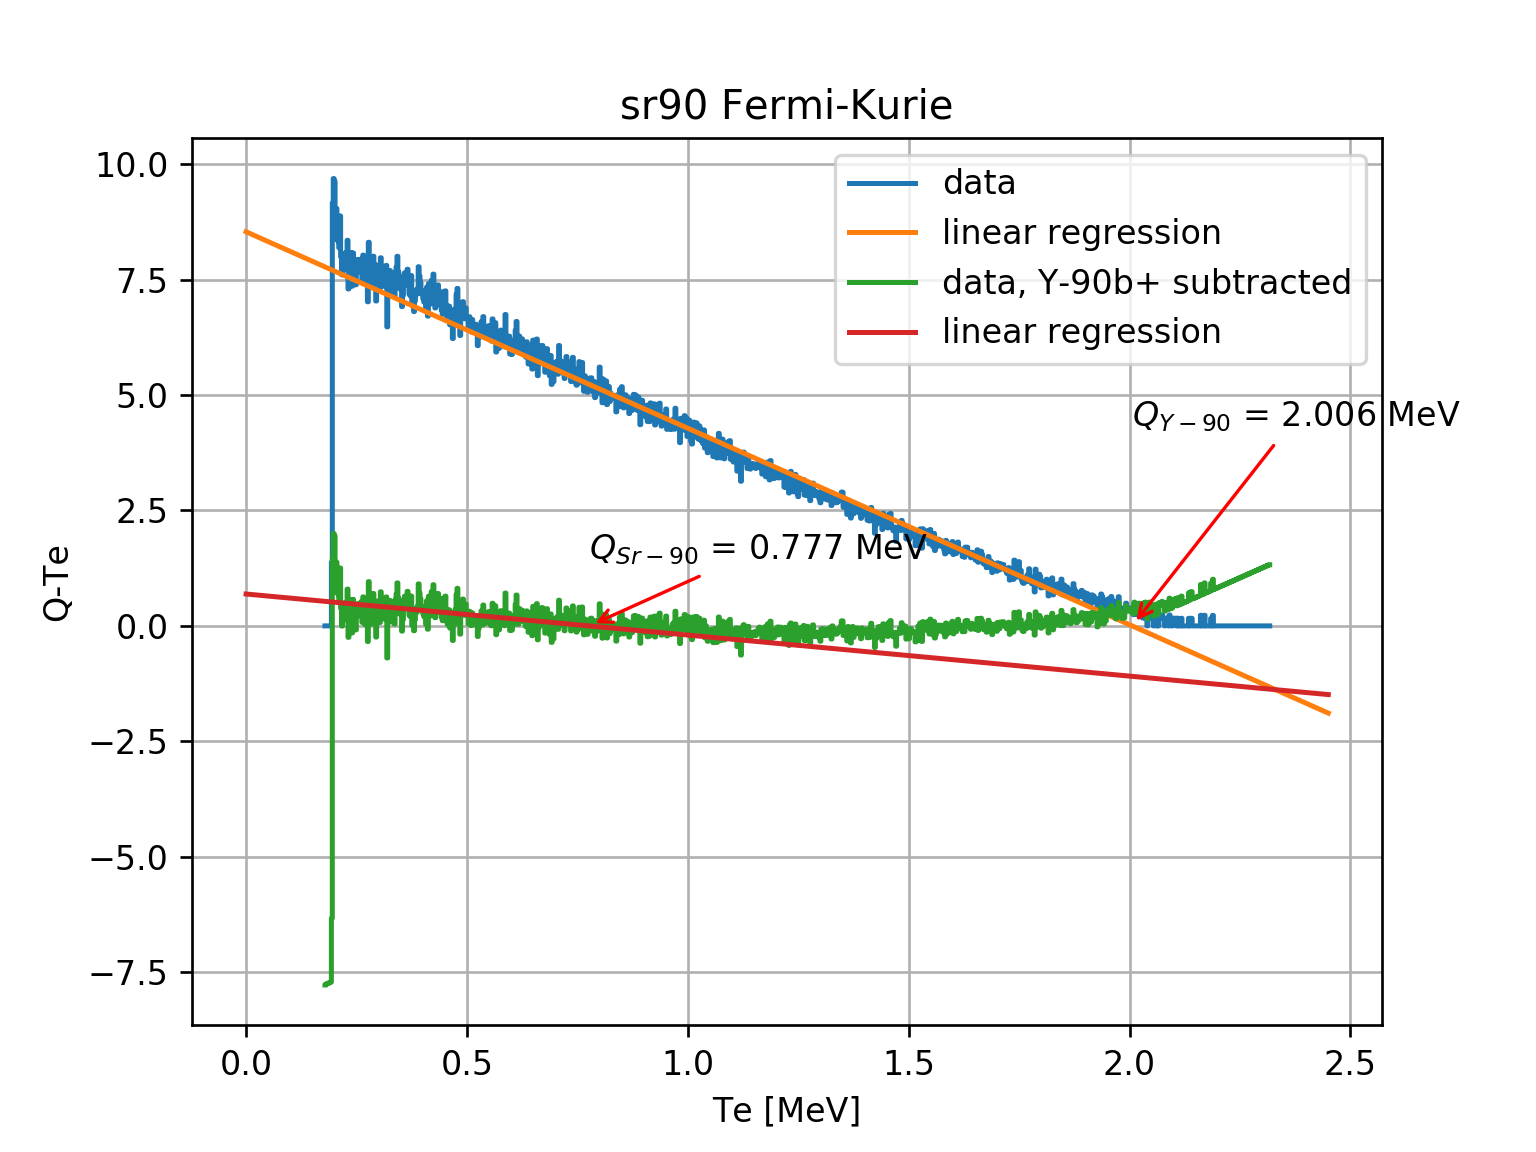

Determined linear regression to Fermi-Kurie plot: Q-Te = -4.25416014085*Te + 8.53419961382
===> Q value: Q = 2.00608329993 MeV 
Determined linear regression to Fermi-Kurie plot: Q-Te = -0.888808637443*Te + 0.690467979951
===> Q Sr-90 value: Q = 0.776846613391 MeV 


In [18]:
## fermi-kurie calculations:
mec2 = 0.510998910 ## e mass in MeV
pc = np.sqrt((sr90.x + mec2)**2 - mec2**2)
A = pc/mec2
f = 1.3604*A*A + 0.1973*A + 0.0439
Ee = (sr90.x + mec2)
QminTe = np.sqrt((sr90.y*pc)/(Ee*f))

## not plot the calculated data
fig, axes = plt.subplots() # makes new plot
plt.grid(True)
plt.xlabel('Te [MeV]')
plt.ylabel('Q-Te')
plt.title("{} Fermi-Kurie".format(sr90.name))
plt.plot(sr90.x, QminTe, label="data", linestyle="steps")
    
## linear regression of the F-K plot see
## http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.linregress.html
## the fit does not really work on the edges of the F-K plot, so we
## take the linear region of lower_limit<E [MeV]<upper_limit (to
## be determined from the plot)
lower_limit, upper_limit = 1,11 ## initialize
try:
    ## search for the bins that match our criteria
    ## first elements ([0][0]) indicate first bin matching our criteria
    lower_limit = np.where(sr90.x>0.5)[0][0]
    upper_limit = np.where(sr90.x>2.)[0][0]
except IndexError:
    print("Could not find any bins to fit! Please check the limit settings!")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    sr90.x[lower_limit:upper_limit], QminTe[lower_limit:upper_limit])

x = np.arange(0,2.5,0.05) ## generate x axis for fit result (start, stop, stepsize)
plt.plot(x,slope*x+intercept,label="linear regression")

## now the Q value is determined by where the linear regression 
## intersects with the x axis (Q-Te = 0)
Q = -intercept/slope

## print results
print("Determined linear regression to Fermi-Kurie plot: Q-Te = " 
          + str(slope)+"*Te + " + str(intercept))
print("===> Q value: Q = "+str(Q)+" MeV ")
## label plot with Q value
plt.annotate(r'$Q_{Y-90}$ = '+"{:.3f}".format(Q)+' MeV', # text to put there
            xy=(Q, 0),                         # where to point to
            xytext=(0., 60),                   # offset for text
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = 'red'))

## try to fit the Sr-90 beta+ decay by subtracting Y-90 beta+ first
QminTe -= sr90.x*slope+intercept
plt.plot(sr90.x, QminTe, label="data, Y-90b+ subtracted", linestyle="steps")
## fit the Sr-90b+:
lower_limit = np.where(sr90.x>0.3)[0][0]
upper_limit = np.where(sr90.x>0.7)[0][0]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    sr90.x[lower_limit:upper_limit], QminTe[lower_limit:upper_limit])
plt.plot(x,slope*x+intercept,label="linear regression")

Q = -intercept/slope
print("Determined linear regression to Fermi-Kurie plot: Q-Te = " 
          + str(slope)+"*Te + " + str(intercept))
print("===> Q Sr-90 value: Q = "+str(Q)+" MeV ")
plt.annotate(r'$Q_{Sr-90}$ = '+"{:.3f}".format(Q)+' MeV', # text to put there
            xy=(Q, 0),                         # where to point to
            xytext=(0., 20),                   # offset for text
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = 'red'))

plt.legend()